In [87]:
import tensorflow as tf
import numpy as np
from scipy import integrate
import random
import matplotlib.pyplot as plt


#  生成数据

In [3]:
# 需要指定一些超参数
delta_t = 0.02*np.pi

In [4]:
def generate_data(n):
    x=np.linspace(0,2*np.pi,256)
    data_train = np.zeros((32,n),dtype = np.float32)
    #data_sol = np.zeros((256,n))
    for k in range(n):
        def f(x):
            return np.sin(x-k*delta_t)
        for i in range(32):
            data_train[i,k]=np.mean([f(x[i*8+j]) for j in range(8)])
    return data_train

In [5]:
data_train = generate_data(20)

# the training model  试试软限制

In [6]:
#确定一些超参数
stencil_length=5
delta_x = 2*np.pi/32


In [7]:
#对于周期函数，翻转函数可以变变
#定义一个向右翻转列向量 ， 
def in_turn1(nums):
    shape = nums.shape
    nums1 = np.zeros(shape)
    nums1[:-1] = nums[1:]
    nums1[-1] = nums[0]
    return nums1
#定义一个向左翻转列向量
def in_turn(nums):
    shape = nums.shape
    nums1 = np.zeros(shape)
    nums1[1:] = nums[:-1]
    nums1[0] = nums[-1]
    return nums1

In [76]:
class Branch(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.convd1=tf.keras.layers.Conv1D(4,3,strides=1,padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.5),activation=tf.nn.relu,use_bias=True,kernel_initializer=tf.random_normal_initializer(stddev=0.067),bias_initializer=tf.zeros_initializer)
        #self.convd2=tf.keras.layers.Conv1D(10,3,strides=1,padding='valid',kernel_regularizer=tf.keras.regularizers.l2(0.1),activation=tf.nn.tanh,use_bias=True,kernel_initializer=tf.random_normal_initializer(stddev=0.077),bias_initializer=tf.zeros_initializer)
        self.convd3=tf.keras.layers.Conv1D(1,2,strides=1,padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.5),activation=tf.nn.relu,use_bias=True,kernel_initializer=tf.random_normal_initializer(stddev=0.099),bias_initializer=tf.zeros_initializer)
        #self.flatten = tf.keras.layers.GlobalAveragePooling1D()
    def call(self,inputs):
        x = self.convd1(inputs)
        #x = self.convd2(x)
        x = self.convd3(x)
        return x

In [100]:
class LocationModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.linear1 = tf.keras.layers.Dense(units=20,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.5),kernel_initializer=tf.random_normal_initializer(stddev=0.099),bias_initializer=tf.zeros_initializer)
       # self.linear2=tf.keras.layers.Dense(units=20,activation=tf.nn.tanh,kernel_regularizer=tf.keras.regularizers.l2(0.9),kernel_initializer=tf.random_normal_initializer(stddev=0.05),bias_initializer=tf.zeros_initializer)
        self.linear3=tf.keras.layers.Dense(units=4,activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.5),kernel_initializer=tf.random_normal_initializer(stddev=0.0625),bias_initializer=tf.zeros_initializer)
    
    def call(self, inputs):
        x = self.linear1(inputs)
       # x = self.linear2(x)
        x = self.linear3(x)
        
        return x

In [101]:
class GlobalModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.location = LocationModel()
        self.branch = Branch()
        
    def call(self, inputs):
        X1,X2 = inputs[0],inputs[1]
        weights2 = self.location(X2)
        weights1 = self.branch(X1)
        
        return weights1,weights2

In [104]:
model = Branch()
#超参数设置
initial_learning_rate=0.01
batch_size = 32
num_epochs=int(1500)
learning_rate_fn=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate,decay_steps=1200,decay_rate=0.99,staircase=True)
#optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
# optimizer1=tf.keras.optimizers.Adamax(learning_rate=learning_rate_fn)#adam对比
# optimizer2=tf.keras.optimizers.Adamax(learning_rate=0.001)#adam对比
# checkpoint1=tf.train.Checkpoint(myModel=trunk)#实例化checkpoint，指定保存对象
# checkpoint2=tf.train.Checkpoint(myModel=branch)
optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate_fn)
checkpoint=tf.train.Checkpoint(myModel=model)
loss_all=[]

In [58]:
def norm(weights_sum):
    for i in range(2,32):
        temp = weights_sum[i,0]+weights_sum[i-1,1]+weights_sum[i-2,2]
        weights_sum[i,0], weights_sum[i,1], weights_sum[i,2] = temp, temp, temp
    temp1 = weights_sum[0,0]+weights_sum[-1,-2]+weights_sum[-2,-1]
    weights_sum[0,0],weights_sum[-1,-2],weights_sum[-2,-1] = temp1,temp1,temp1
    temp2 = weights_sum[0,1]+weights_sum[1,0]+weights_sum[-1,-1]
    weights_sum[0,1],weights_sum[1,0],weights_sum[-1,-1] = temp2,temp2,temp2

In [103]:
#@tf.function
def loss_coe(X):
    Y=np.zeros((32,1),dtype = np.float32)
    Y[0]=X[0,2]+X[1,1]+X[2,0]+X[-2,-1]+X[-1,-2]
    Y[1]=X[0,3]+X[1,2]+X[2,1]+X[3,0]+X[-1,-1]
    # Y[2]=X[2,0]+X[1,1]+X[0,2]+X[-1,-2]+X[-2,-1]
    # Y[3]=X[3,0]+X[2,1]+X[1,2]+X[0,3]+X[-1,-1]
    for i in range(4,32):
        Y[i-2]=X[i,0]+X[i-1,1]+X[i-2,2]+X[i-3,1]+X[i-4,0]
    Y[-2]=X[0,0]+X[-1,-4]+X[-2,-3]+X[-3,-2]+X[-4,-1]
    Y[-1]=X[1,0]+X[0,1]+X[-1,-3]+X[-2,-2]+X[-3,-1]
    return Y-1
    



In [106]:
def run_train_model(n):  #卷积核大小设成2
    num = 0
    for epoch in range(num_epochs):
        ujn= data_train[:,0].reshape(32, 1)
        ujn_1 = in_turn(ujn)
        ujn_2 = in_turn(ujn_1)
        ujn1 = in_turn1(ujn)
        ujn2 = in_turn1(ujn1)
        features = np.c_[ujn_2,ujn_1,ujn,ujn1,ujn2].reshape(32,5,1)
        
        labels = data_train[:,1].reshape(32,1)
        # locations = np.array([-delta_t/delta_x]*32,dtype = np.float32).reshape(32,1)#归一化后的
        X1,  Y = features, labels
        with tf.GradientTape(persistent=True) as tape:
            weights1= model(X1)
            weights = tf.squeeze(weights1)
            #print(weights[0,0])
            # weights_norm = transform(weights)
            # # weights_norm = 1-tf.reduce_sum(weights,axis=1, keepdims=True)
            # weights = tf.concat([weights, weights_norm],1)
            # print(weights_norm.shape)
            # break
            #归一化处理
            # weights_sum = weights.numpy()
            # weights_sum = norm(weights_sum)
            # weights = weights/weights_sum
            # print(weights)
            # print(X1)
            # break
            y_pred = tf.reduce_sum(weights*np.squeeze(X1),axis=1,keepdims=True)
            loss = tf.reduce_sum(tf.square(y_pred-Y))+0.5*tf.reduce_sum(tf.square(loss_coe(weights)))
        grads=tape.gradient(loss,model.variables)
        del tape
        optimizer.apply_gradients(grads_and_vars=zip(grads,model.variables))
        for k in range(1, n):
            weights1= model(features)
            weights = tf.squeeze(weights1)
            # weights_norm = 1-tf.reduce_sum(weights,axis=1, keepdims=True)
            # weights_norm = transform(weights)
            # weights = tf.concat([weights, weights_norm],1)
            pred = tf.reduce_sum(weights*np.squeeze(features),axis=1,keepdims=True)
            ujn= pred.numpy()
            ujn_1 = in_turn(ujn)
            ujn_2 = in_turn(ujn_1)
            ujn1 = in_turn1(ujn)
            ujn2 = in_turn1(ujn1)
            features = np.c_[ujn_2,ujn_1,ujn,ujn1,ujn2].reshape(32,5,1)
            # features = np.c_[in_turn(features),features, in_turn1(features)].reshape(32,3,1)
            labels = data_train[:,k+1].reshape(32,1)
            # locations = np.array([-delta_t/delta_x]*32).reshape(32,1)#归一化后的
            X1, Y = features, labels
            with tf.GradientTape(persistent=True) as tape:
                weights1 = model(X1)
                weights = tf.squeeze(weights1)
                # weights_norm = 1-tf.reduce_sum(weights,axis=1, keepdims=True)
                # weights_norm = transform(weights)
                # weights = tf.concat([weights, weights_norm],1)
                y_pred = tf.reduce_sum(weights*np.squeeze(X1),axis=1,keepdims=True)
                loss = tf.reduce_sum(tf.square(y_pred-Y))+0.5*tf.reduce_sum(tf.square(loss_coe(weights)))
            grads=tape.gradient(loss,model.variables)
            del tape
        if epoch%10==0:
            print(num,':',loss)
            num+=1





In [111]:
run_train_model(5)

0 : tf.Tensor(0.5388777, shape=(), dtype=float32)
1 : tf.Tensor(0.53940123, shape=(), dtype=float32)
2 : tf.Tensor(0.5398968, shape=(), dtype=float32)
3 : tf.Tensor(0.5403648, shape=(), dtype=float32)
4 : tf.Tensor(0.5408071, shape=(), dtype=float32)
5 : tf.Tensor(0.5412239, shape=(), dtype=float32)
6 : tf.Tensor(0.5416165, shape=(), dtype=float32)
7 : tf.Tensor(0.5419855, shape=(), dtype=float32)
8 : tf.Tensor(0.54233134, shape=(), dtype=float32)
9 : tf.Tensor(0.5426565, shape=(), dtype=float32)
10 : tf.Tensor(0.54296064, shape=(), dtype=float32)
11 : tf.Tensor(0.54324424, shape=(), dtype=float32)
12 : tf.Tensor(0.54350924, shape=(), dtype=float32)
13 : tf.Tensor(0.54375595, shape=(), dtype=float32)


KeyboardInterrupt: 

In [89]:
x = np.arange(0,2*np.pi, delta_x)

In [90]:
len(x)

32

In [108]:
def run_pred(n):
    ujn= data_train[:,0].reshape(32, 1)
    ujn_1 = in_turn(ujn)
    ujn_2 = in_turn(ujn_1)
    ujn1 = in_turn1(ujn)
    ujn2 = in_turn1(ujn1)
    features = np.c_[ujn_2,ujn_1,ujn,ujn1,ujn2].reshape(32,5,1)
    weights1= model(features)
    weights = tf.squeeze(weights1)
    pred = tf.reduce_sum(weights*np.squeeze(features),axis=1,keepdims=True)
    y_pred = pred.numpy()
    for k in range(1, n):
        ujn = y_pred
        ujn_1 = in_turn(ujn)
        ujn_2 = in_turn(ujn_1)
        ujn1 = in_turn1(ujn)
        ujn2 = in_turn1(ujn1)
        features = np.c_[ujn_2,ujn_1,ujn,ujn1,ujn2].reshape(32,5,1)
        weights1= model(features)
        weights = tf.squeeze(weights1)
        pred = tf.reduce_sum(weights*np.squeeze(features),axis=1,keepdims=True)
        y_pred = pred.numpy()
    labels = data_train[:,n].reshape(32,1)
    plt.figure(figsize=(8,8))
    plt.plot(x,y_pred,c='r',linestyle='dotted',linewidth=4,label='pred')
    plt.plot(x,labels,c='b',linestyle='-',linewidth=2,label='true')
    #plt.ylim(-1,1)
    plt.legend(loc='upper right')
    plt.title('t='+str(n*delta_t))
    plt.show()
    #print(labels_test)
    #print(pred1)
    loss_2=np.sqrt(np.sum(np.power(y_pred-labels,2))*delta_x)/np.sqrt(2*np.pi) 
    print('l2',loss_2)
    loss_infty=np.max(np.abs(y_pred-labels))
    print('l_infty',loss_infty)
        
        

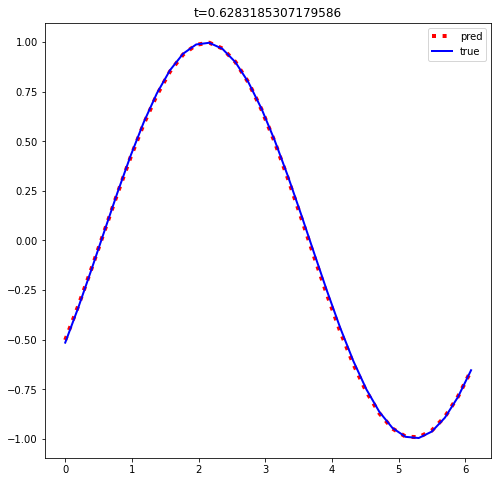

l2 0.00875701542036823
l_infty 0.018304884


In [110]:
run_pred(10)

In [20]:
import tensorflow as tf
X = tf.constant([[[1., 1, 1],[2., 2, 2]],
                  [[3, 3, 3],[4, 4, 4]]])
y_1= tf.reduce_sum(X) #全部和
y_2= tf.reduce_sum(X,1) #沿着轴1求和
y_3= tf.reduce_sum(X,1,keepdims=True)
#y_4= tf.reduce_sum(X,[1,0])#先沿着轴1再轴0
print(X.shape,y_1.shape,y_2.shape,y_3.shape)


(2, 2, 3) () (2, 3) (2, 1, 3)
